# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- Try and merge other currencies into USD columns? Might increase # stocks by a lot
- Need to try and fix some columns, like Revenue USD Mil

In [61]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [185]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
#tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")

tickers = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
tickers = tickers.loc[tickers['MarketCap']>1e6]  #exclude stocks with small market cap
tickers.head()

813


,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",6.5001,3.873322e+07,n/a,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih,NaN
1,FCCY,1st Constitution Bancorp (NJ),18,1.436993e+08,n/a,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy,NaN
2,SRCE,1st Source Corporation,44.82,1.159751e+09,n/a,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce,NaN
3,ABIL,Ability Inc.,3.21,8.267722e+07,n/a,2014,Finance,Business Services,http://www.nasdaq.com/symbol/abil,NaN
4,ABM,ABM Industries Incorporated,40.86,2.270007e+09,n/a,n/a,Finance,Diversified Commercial Services,http://www.nasdaq.com/symbol/abm,NaN


## Get Data

In [ ]:
#small helper function for get_mean_frac_price_change
def first_and_last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BMS'), pd.date_range(date, periods=1, freq='BM')

#collects data from yahoo finance, gets mean fractional price change, averaged over the relevant month
def get_mean_frac_price_change(stock,current_date):
    ds = current_date.split('-')
    first_current, last_current = first_and_last_weekday_of_month(current_date)
    first_future, last_future = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    first_past, last_past = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])-1, ds[1]))
    mean_current_price = DataReader(stock, 'yahoo', first_current, last_current)['Adj Close'].mean()
    mean_future_price = DataReader(stock, 'yahoo', first_future, last_future)['Adj Close'].mean()
    mean_past_price = DataReader(stock, 'yahoo', first_past, last_past)['Adj Close'].mean()
    return mean_future_price/mean_current_price, mean_current_price/mean_past_price
    
#simple progress bar
def progress_bar(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item

#scrape financial data from Morningstar
def get_stock_financials(stock,year,YOY):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK','OMR','AED']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    #scrape/load data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    #ignore if non-US stocks for consistency
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):            #delete if present
            return pd.DataFrame(columns=d.columns)         #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    #delete annoying repeated columns
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    #get data
    i1 = np.where(d['index'].str.contains("%d"%year))[0][0]
    current_date=d['index'].iloc[i1]
    if YOY==1:    #Get ratios of each feature from current and previous year
        i2 = np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
        values = pd.to_numeric(d.iloc[i1], errors='coerce')/pd.to_numeric(d.iloc[i2], errors='coerce')
    else:
        values = pd.to_numeric(d.iloc[i1], errors='coerce')
    d = pd.DataFrame(values).transpose()
    MFFPC, MPFPC = get_mean_frac_price_change(stock,current_date)
    d['Stock'] = stock                                     #keep stock ticker
    d['Mean Past Fractional Price Change'] = MPFPC         #fractional price change (current/past) -> for features
    d['Mean Future Fractional Price Change'] = MFFPC       #fractional price change (future/current) -> for target
    return d
        
#Top-level function which acquires all the data
def get_data(ticker_csv,year,true_threshold,YOY):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_year%d_YOY%d_data.csv"%(ticker_loc,year,YOY))
        skip = np.loadtxt("%s_year%d_YOY%d_skip.csv"%(ticker_loc,year,YOY), dtype="str",delimiter=",")
        print "Loaded data from csv's..."
    except:
        print "Couldn't find DataFrame, scraping data from Morningstar..."
        #create empty dataframe with available columns
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],year,0).columns
        X = pd.DataFrame(columns=cols)
        skip = []
        for s in progress_bar(stocks["Symbol"], len(stocks["Symbol"])/10):
            try:
                _X = get_stock_financials(s,year,YOY)
                if _X.shape[1] > 1: #only append if alg actually recovered data
                    X = X.append(_X)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        #save to csv for ease of loading next time
        skip = np.asarray(skip)
        X.to_csv("%s_year%d_YOY%d_data.csv"%(ticker_loc,year,YOY))
        np.savetxt("%s_year%d_YOY%d_skip.csv"%(ticker_loc,year,YOY), skip, fmt="%s", delimiter=",")
    #create target
    y = np.zeros(X.shape[0])
    y[np.where(X['Mean Future Fractional Price Change']>true_threshold)] = 1
    return X, y, skip

Load the data below. This could take a minute.

In [ ]:
year = 2015
true_threshold=1.2  #Minimum fractional change in price required for target=True (=1). Otherwise False (=0). 
YOY = 0             #if =1, express features as year_{i}/year_{i-1}, i.e. year-over-year
ticker_csv = "csv/wilshire5000.csv"
#ticker_csv = 'csv/nasdaq/Finance.csv'

X, y, skip = get_data(ticker_csv, year, true_threshold, YOY)

In [240]:
#Relative class numbers
print "Number of True cases = %d"%len(y[y==1])
print "Number of False cases = %d"%len(y[y==0])

Number of True cases = 1669
Number of False cases = 775


## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [241]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            #X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "!couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

**Deleted** Accounts Payable: NaN fraction = 0.2066
Accounts Receivable: NaN fraction = 0.0651
**Deleted** Accrued Liabilities: NaN fraction = 0.1669
Asset Turnover: NaN fraction = 0.0192
Asset Turnover (Average): NaN fraction = 0.0192
Book Value Per Share * USD: NaN fraction = 0.0074
**Deleted** COGS: NaN fraction = 0.2091
Cap Ex as a % of Sales: NaN fraction = 0.0495
**Deleted** Cap Spending USD Mil: NaN fraction = 0.1109
Cash & Short-Term Investments: NaN fraction = 0.0053
**Deleted** Cash Conversion Cycle: NaN fraction = 0.4157
**Deleted** Current Ratio: NaN fraction = 0.1567
**Deleted** Days Inventory: NaN fraction = 0.3940
**Deleted** Days Sales Outstanding: NaN fraction = 0.1960
**Deleted** Debt/Equity: NaN fraction = 0.2582
**Deleted** Dividends USD: NaN fraction = 0.4493
EBT Margin: NaN fraction = 0.0258
Earnings Per Share USD: NaN fraction = 0.0053
Financial Leverage: NaN fraction = 0.0548
Financial Leverage (Average): NaN fraction = 0.0548
Fixed Assets Turnover: NaN fraction

In [242]:
X.columns

Index([u'Accounts Receivable', u'Asset Turnover', u'Asset Turnover (Average)',
       u'Book Value Per Share * USD', u'Cap Ex as a % of Sales',
       u'Cash & Short-Term Investments', u'EBT Margin',
       u'Earnings Per Share USD', u'Financial Leverage',
       u'Financial Leverage (Average)', u'Fixed Assets Turnover',
       u'Free Cash Flow Per Share * USD', u'Free Cash Flow/Net Income',
       u'Free Cash Flow/Sales %', u'Mean Future Fractional Price Change',
       u'Mean Past Fractional Price Change', u'Net Income USD Mil',
       u'Net Int Inc & Other', u'Net Margin %', u'Net PP&E',
       u'Operating Margin', u'Operating Margin %', u'Return on Assets %',
       u'Return on Equity %', u'Revenue', u'SG&A', u'Shares Mil',
       u'Total Assets', u'Total Liabilities', u'Total Liabilities & Equity',
       u'Total Stockholders' Equity'],
      dtype='object')

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [243]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
X['P/E Ratio'] = X['Mean Past Fractional Price Change']/X['Earnings Per Share USD']                 
X['P/B Ratio'] = X['Mean Past Fractional Price Change']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

#
#features to include for analysis
percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %','Cap Ex as a % of Sales']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD',
          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover', 'Financial Leverage']
other = ['Cash & Short-Term Investments','EBT Margin']

features = ratios + percentiles + other

In [244]:
X[features].head()

,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover,Financial Leverage,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Cap Ex as a % of Sales,Cash & Short-Term Investments,EBT Margin
Stock,,,,,,,,,,,,,,,,,
A,12.36,1.20,0.90,2.258356,0.783213,0.076040,0.794688,0.44,1.79,9.93,8.47,4.38,12.9,9.73,2.43,26.78,11.89
AAME,5.05,0.19,0.21,1.483239,6.517842,0.245226,2.069368,0.53,3.07,2.40,3.86,1.26,3.4,1.14,0.19,4.97,3.44
AAN,18.50,1.86,1.72,2.057613,0.432007,0.043434,0.945525,1.24,1.95,4.27,10.48,5.31,7.4,3.34,1.90,1.40,6.70
AAON,3.74,0.84,0.62,4.317789,1.314808,0.295305,0.301406,1.54,1.30,12.75,25.91,19.63,19.9,8.91,5.85,8.74,19.89
AAP,32.94,6.40,6.26,1.433692,0.151526,0.029440,2.305785,1.21,3.31,4.84,21.14,5.86,8.5,4.67,2.41,1.12,7.73


In [245]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [246]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [247]:
#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.44786729857819907

In [248]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
n_iter = 15     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.1,0.5,1],
    'gamma': [0,0.2,0.4,0.8],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.710558447539
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 0.5, 'n_estimators': 1000, 'max_depth': 2, 'gamma': 0.8}


In [249]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
best_params={
    'learning_rate': [5e-3],
    'n_estimators':[3000],
    'max_depth': [2],
    'min_child_weight': [3],
    'colsample_bytree': [0.5],
    'gamma': [0.8],
}
final_model = GridSearchCV(model, param_grid=best_params, cv=n_cv, scoring='roc_auc')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

0.715324173084


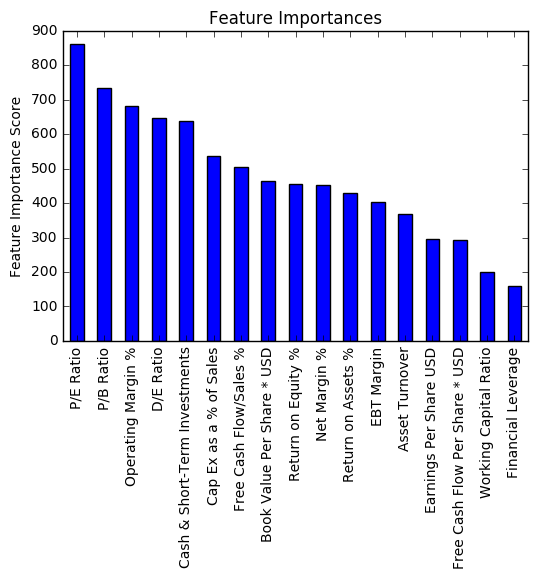

In [250]:
#seems equivalent to model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

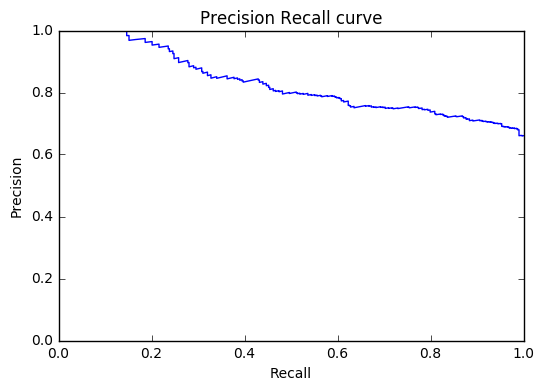

In [251]:
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

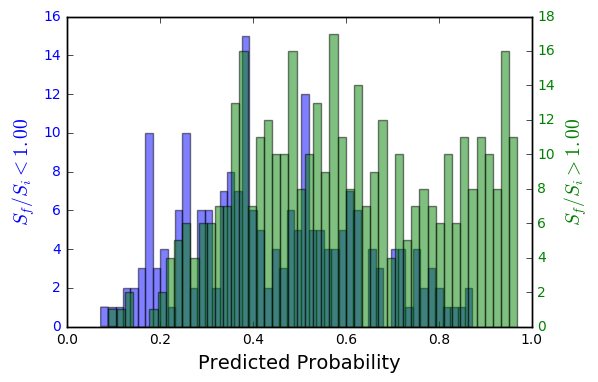

In [252]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]

fig, ax1 = plt.subplots()
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('$S_f/S_i<%.2f$'%true_threshold,  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('$S_f/S_i>%.2f$'%true_threshold, fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

# Extra

In [36]:
XX = X_test
XX['y_pred'] = y_pred[:,1]
XX['y_test'] = y_test
XX.head()

,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Cap Ex as a % of Sales,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover,Financial Leverage,y_pred,y_test
1598,0.906746,1.037358,0.964687,1.008621,1.000561,0.817143,0.949461,0.956284,0.946903,0.993174,0.925408,1.451823,1.462255,1.221928,1.064516,1.131687,0.055927,0.0
620,1.653061,1.515385,1.414634,0.958333,0.036800,0.245747,1.130788,1.670732,-0.192090,1.153005,1.004233,2.401226,3.547796,0.971822,0.867470,0.975182,0.000460,0.0
1266,0.851986,0.775388,0.786227,0.511111,1.137579,1.073034,1.073663,0.827160,0.423729,0.518055,1.120737,0.921339,0.709808,0.873764,0.920635,0.975000,0.970860,1.0
649,0.158382,0.138399,0.119332,0.377483,0.096491,2.085470,0.968100,0.135484,0.681159,0.150738,0.930813,5.781380,0.809094,1.157813,0.750000,1.076142,0.964769,1.0
1908,1.050256,1.009162,1.029792,1.045161,0.901024,1.303922,1.057778,1.111111,0.893333,1.052733,1.109525,0.702828,0.738265,0.839412,0.983516,0.931429,0.980430,1.0


In [51]:
XX[(XX['y_test']==1) & (XX['y_pred']<0.3)].index

Int64Index([2033, 802, 2425, 25, 275], dtype='int64')

In [57]:
index = XX[(XX['y_test']==1) & (XX['y_pred']<0.4)].index
X["Book Value Per Share * USD"].iloc[index]

2033    0.874455
208     1.016921
2132    0.879365
163     0.317043
857     0.073529
802     0.024000
2229    0.952813
2425    0.855476
25      0.109589
283     0.406906
275     0.031536
1309    0.465116
1844    1.042789
Name: Book Value Per Share * USD, dtype: float64

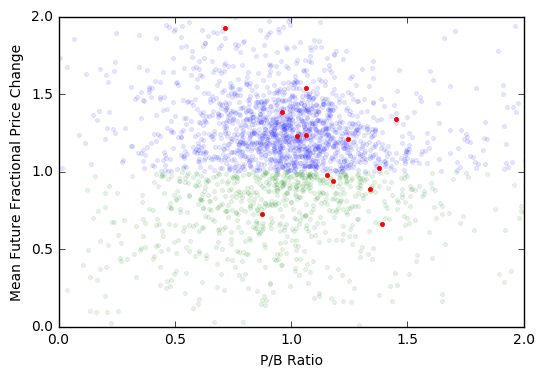

In [78]:
feature="P/B Ratio"
plt.plot(X.loc[y==1,feature], X.loc[y==1,"Mean Future Fractional Price Change"], '.', alpha=0.1)
plt.plot(X.loc[y==0,feature], X.loc[y==0,"Mean Future Fractional Price Change"], '.', alpha=0.1)

index = XX[(XX['y_test']==1) & (XX['y_pred']<0.4)].index
plt.plot(X[feature].iloc[index], X["Mean Future Fractional Price Change"].iloc[index], '.')
plt.ylim([0,2])
plt.xlim([0,2])
plt.xlabel(feature)
plt.ylabel("Mean Future Fractional Price Change")

Testing

In [ ]:
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK']
del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
stock="A"
d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
d = d.transpose().reset_index()
#date = d['index'].values
#i1,i2 = np.where(d['index'].str.contains("%d"%year))[0][0], np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
#ratios = d.iloc[i1].convert_objects(convert_numeric=True)/d.iloc[i2].convert_objects(convert_numeric=True)
#d = pd.DataFrame(ratios).transpose()
#d.insert(0,'Stock',stock)                              #keep stock ticker
#d.insert(1,'Mean Fractional Price Change',get_mean_frac_price_change(stock,date)) #get fractional price change
l=pd.to_numeric(d.iloc[0], errors='coerce')/pd.to_numeric(d.iloc[1], errors='coerce')
l

In [ ]:
i1=np.where(d['index'].str.contains("%d"%year))[0][0]
date=d['index'].iloc[i1]
get_mean_frac_price_change("ABCB",date)

In [ ]:
plt.plot(X['Earnings Per Share USD'],X['Mean Fractional Price Change'], '.',alpha=0.05)
plt.xlim([-5,5])
plt.ylim([0,4])

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [ ]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [ ]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [ ]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [ ]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()